In [ ]:
# pandas, matplotlib, seaborn csv 불러오기
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

from IPython.display import set_matplotlib_formats
#폰트가 선명하게 보이기 위해
set_matplotlib_formats('retina')

file_path = "/content/drive/MyDrive/0 기계학습/팀플/Salary.csv"
df = pd.read_csv(file_path)
salary_data = df

salary_data.head()

<ipython-input-19-062a1c18ed2d>:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


Age  Gender  Education Level          Job Title  Years of Experience  \
0  32.0    Male                1  Software Engineer                  5.0   
1  28.0  Female                2       Data Analyst                  3.0   
2  45.0    Male                3            Manager                 15.0   
3  36.0  Female                1    Sales Associate                  7.0   
4  52.0    Male                2           Director                 20.0   

     Salary Country      Race  Senior  
0   90000.0      UK     White       0  
1   65000.0     USA  Hispanic       0  
2  150000.0  Canada     White       1  
3   60000.0     USA  Hispanic       0  
4  200000.0     USA     Asian       0

## 상관관계

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 범주형 변수를 수치형으로 변환하기 위해 원-핫 인코딩 적용
# 'Job Title'을 제외한 나머지 범주형 피쳐 선택
categorical_features_without_job = ['Gender', 'Country', 'Race']

# 원-핫 인코딩 적용
onehot_encoded_data = pd.get_dummies(df, columns=categorical_features_without_job)
df = onehot_encoded_data


# 직업명 드랍
df = df.drop('Job Title', axis=1)

In [ ]:
df

In [ ]:
# 변수들 간의 상관관계 계산
plt.rc('font', family='AppleGothic')
correlation_matrix = df.corr()

# 상관관계 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('변수별 상관관계')
plt.show()

In [ ]:
job_counts = salary_data['Job Title'].value_counts()

plt.rc('font', family='AppleGothic')

plt.figure(figsize=(20, 30))
sns.barplot(y=job_counts.index, x=job_counts.values)
plt.title('직업 별 개수 분포')
plt.xlabel('개수')
plt.ylabel('직업')
plt.show()

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 데이터 불러오기
data = pd.read_csv(file_path)

# 'Front End Developer'를 'Front end Developer'로 변경
data['Job Title'] = data['Job Title'].replace('Front End Developer', 'Front end Developer')

# 제외할 직종 목록
exclude_titles = ['Copywriter', 'Data Entry Clerk', 'Director of Human Capital',
                  'Support Specialist', 'Technical Recruiter', 'Recruiter']

# 제외할 직종 제거
data = data[~data['Job Title'].isin(exclude_titles)]

# IT 및 소프트웨어 관련 직종 필터링
it_sw_keywords = ['Software', 'Developer', 'Engineer', 'Data', 'System', 'IT', 'Tech', 'Programmer', 'Web', 'Network']
it_sw_related_jobs = data[data['Job Title'].str.contains('|'.join(it_sw_keywords), case=False)]

# 원-핫 인코딩 적용
categorical_columns = ['Job Title', 'Gender', 'Education Level', 'Country', 'Race', 'Senior']
encoder = OneHotEncoder(sparse=False)
encoded_data = encoder.fit_transform(it_sw_related_jobs[categorical_columns])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns))
combined_data = pd.concat([it_sw_related_jobs.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_df], axis=1)

# 랜덤 포레스트 모델 구축 및 평가
X = combined_data.drop('Salary', axis=1)
y = combined_data['Salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R² score: {r2}")

In [ ]:
# 'Country' 관련 원-핫 인코딩된 열들 찾기
country_columns = [col for col in combined_data.columns if col.startswith('Country_')]

# 'Job Title' 관련 원-핫 인코딩된 열들 찾기
job_title_columns = [col for col in combined_data.columns if col.startswith('Job Title_')]

# 각 국적별 직종별 종사자 수 계산
country_job_title_counts = {}
for country_col in country_columns:
    country_data = combined_data[combined_data[country_col] == 1]
    job_counts = country_data[job_title_columns].sum()
    country_job_title_counts[country_col] = job_counts

# 결과 출력
for country, counts in country_job_title_counts.items():
    print(f"{country}:\n{counts.sort_values(ascending=False)}\n")

In [ ]:
# 각 국가별 직종별 종사자 수 합계
total_job_title_counts = pd.DataFrame(country_job_title_counts).sum(axis=1)

# 합계가 0인 직군 제거
filtered_job_titles = total_job_title_counts[total_job_title_counts > 0]

# 필터링된 직군 종사자 수 출력
print(filtered_job_titles.sort_values(ascending=False))

In [ ]:
# 각 'Job Title' 열에 대한 표본 수 계산
job_title_sample_counts = combined_data[job_title_columns].sum()

# 표본 수가 10개 미만인 'Job Title' 열 식별
low_sample_job_titles = job_title_sample_counts[job_title_sample_counts < 10].index

# 해당 열에서 값이 1인 행 제거
for job_title_col in low_sample_job_titles:
    combined_data = combined_data[combined_data[job_title_col] == 0]

# 제거 후 행의 개수 확인
print(f"Number of rows after removal: {len(combined_data)}")

In [ ]:
# 각 직업의 표본 수 계산
job_title_sample_counts = combined_data[job_title_columns].sum(axis=0)

# 표본 수가 10개 미만인 직업 확인
low_sample_job_titles = job_title_sample_counts[job_title_sample_counts < 10].index

# 이러한 직업을 가진 행들 제거
for job_title_col in low_sample_job_titles:
    combined_data = combined_data[combined_data[job_title_col] == 0]

# 훈련 및 테스트 세트 분할
X = combined_data.drop('Salary', axis=1)
y = combined_data['Salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 재훈련 및 평가
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R² score: {r2}")

In [ ]:
# 각 직군별 종사자 수 계산
job_title_counts = combined_data[job_title_columns].sum()

# 결과 출력
print(job_title_counts.sort_values(ascending=False))

# 모델 설계

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder



# 목표 변수(연봉)와 예측 변수 분리
X = encoded_data.drop('Salary', axis=1)
y = encoded_data['Salary']

# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 선형 회귀 모델 구축 및 훈련
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# 테스트 세트에 대한 예측 수행
y_pred_linear = linear_model.predict(X_test)

# 선형 회귀 모델의 성능 메트릭 계산
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# 랜덤 포레스트 회귀 모델 구축 및 훈련
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 랜덤 포레스트 모델의 성능 메트릭 계산
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mse_linear, r2_linear, mse_rf, r2_rf

# 연봉 예측 수행

In [ ]:
import random

# 데이터 로드 및 기초 전처리
numerical_features = ['Age', 'Education Level', 'Years of Experience', 'Senior']
categorical_features = ['Gender', 'Job Title', 'Country', 'Race']
encoded_data = pd.get_dummies(salary_data, columns=categorical_features)

# 연봉에 대한 별도의 스케일러 생성 및 적용
salary_scaler = StandardScaler()
salary_scaled = salary_scaler.fit_transform(salary_data[['Salary']])

# 목표 변수(연봉)와 예측 변수 분리
X_full = encoded_data.drop('Salary', axis=1)
y_full = salary_scaled

# 데이터셋 분할
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# 랜덤 포레스트 회귀 모델 구축 및 훈련
rf_model_full = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_full.fit(X_train_full, y_train_full.ravel())

# 임의의 사용자 정보 생성 및 예측
# random_user_info = {
#     "Age": random.randint(20, 60),
#     "Gender_Male": random.randint(0, 1),
#     "Gender_Female": 1 - random.randint(0, 1),
#     "Education Level": random.randint(1, 3),
#     "Years of Experience": random.uniform(0, 20),
#     "Country_America": random.randint(0, 1),
#     "Race_Korean": random.randint(0, 1),
#     "Senior": random.randint(0, 1)
# }
random_user_info = {
    "Age": 26,
    "Gender_Male": 1,
    "Gender_Female": 0,
    "Education Level": 1,
    "Years of Experience": 1,
    "Country_America": 1,
    "Race_Korean": 1,
    "Senior": 0,
}


job_titles = [col for col in X_train_full.columns if col.startswith('Job Title_')]
# random_job_title = random.choice(job_titles)
random_job_title = 'Software Engineer'
random_user_info[random_job_title] = 1
random_user_df = pd.DataFrame([random_user_info])
for col in X_train_full.columns:
    if col not in random_user_df:
        random_user_df[col] = 0
random_user_df = random_user_df[X_train_full.columns]
predicted_random_salary_full = rf_model_full.predict(random_user_df)

# 예측된 연봉을 원래 스케일로 변환
predicted_salary_random_dollars_full = salary_scaler.inverse_transform(predicted_random_salary_full.reshape(-1, 1))[0][0]
predicted_salary_random_dollars_full, random_user_info


시도해볼만한 것들

1. 인종만 바꿔서 차이 봐보기
2. 실제 연봉과 예상 연봉의 차이 보기
3. 나이를 바꿔서 봐보기

## 직종별 연봉 비교

In [ ]:
import random

random_user_info = {
    "Age": 26,
    "Gender_Male": 1,
    "Gender_Female": 0,
    "Education Level": 1,
    "Years of Experience": 1,
    "Country_America": 1,
    "Race_Korean": 1,
    "Senior": 0,
}


job_titles = [col for col in X_train_full.columns if col.startswith('Job Title_')]
# random_job_title = random.choice(job_titles)
random_job_title = 'Research Scientist'
random_user_info[random_job_title] = 1
random_user_df = pd.DataFrame([random_user_info])
for col in X_train_full.columns:
    if col not in random_user_df:
        random_user_df[col] = 0
random_user_df = random_user_df[X_train_full.columns]
predicted_random_salary_full = rf_model_full.predict(random_user_df)

# 예측된 연봉을 원래 스케일로 변환
predicted_salary_random_dollars_full = salary_scaler.inverse_transform(predicted_random_salary_full.reshape(-1, 1))[0][0]
predicted_salary_random_dollars_full, random_user_info


In [ ]:
# 고정된 기본 조건 설정
base_user_info = {
    "Age": 30,  # 30세
    "Gender_Male": 1,  # 남자
    "Gender_Female": 0,  # 여자가 아님
    "Education Level": 2,  # 교육 수준 2
    "Years of Experience": 5,  # 경력 5년
    "Country_USA": 1,  # 미국
    "Race_White": 1,  # 백인
    "Senior": 0  # 선임이 아님
}

# 각 직군에 대해 연봉 예측
salary_predictions_by_job = {}
for job_title in job_titles:
    # 현재 직업에 대한 정보 설정
    user_info = base_user_info.copy()
    user_info[job_title] = 1

    # 사용자 정보를 데이터프레임으로 변환
    user_df = pd.DataFrame([user_info])
    for col in X_train_full.columns:
        if col not in user_df:
            user_df[col] = 0
    user_df = user_df[X_train_full.columns]

    # 예측 수행
    predicted_salary = rf_model_full.predict(user_df)

    # 예측된 연봉을 원래 스케일로 변환
    predicted_salary_original = salary_scaler.inverse_transform(predicted_salary.reshape(-1, 1))[0][0]
    salary_predictions_by_job[job_title] = predicted_salary_original

# 예측 결과 출력 (직업별 연봉)
salary_predictions_by_job

# 입력받아 예측하는 모델

In [ ]:
num_people = len(combined_df[(combined_df['Years of Experience'] == 20) & (combined_df['Job Title_Software Engineer Manager'] == 1)])

print(num_people)

5


나이를 입력해주세요: 20
성별 선택:
1. 남성
2. 여성
해당하는 성별의 숫자를 선택해주세요: 2
교육 정도 선택
1. 고졸
2. 학사
3. 석사
4. 박사
해당하는 학력을 선택해주세요: 2
직업 선택:
1. 소프트웨어 엔지니어
2. 데이터 사이언티스트
3. 데이터 애널리티스트
4. 소프트웨어 엔지니어 매니저
5. 프로젝트 엔지니어
6. 풀스택 엔지니어
7. 프론트엔드 개발자
8. 백엔드 개발자
9. 소프트웨어 개발자
10. 웹 개발자
11. 데이터 사이언스 디렉터
해당하는 직업의 번호를 선택해주세요: 5
경력연수를 기입해주세요: 5
근무 국가 선택
1. 호주
2. 캐나다
3. 중국
4. 영국
5. 미국
근무 희망 국가의 번호를 선택해주세요: 5


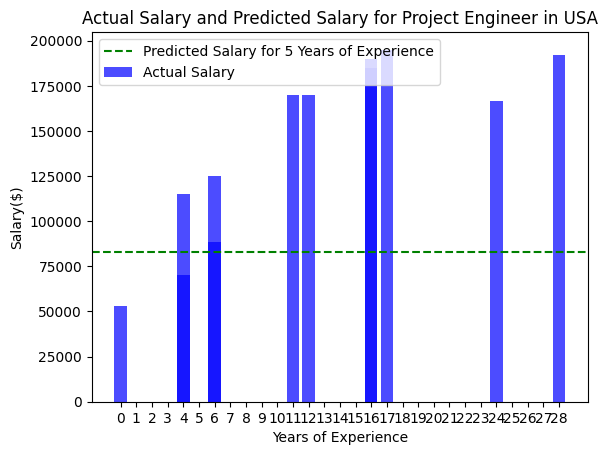

"\n# Plotting the original data as a bar graph\nplt.bar(X_test['Years of Experience'], y_test, color='blue', alpha=0.7, label='Actual Salary')\n\n# Plot the user input prediction as a horizontal line\nplt.axhline(y=user_salary_pred, color='green', linestyle='--', label=f'Predicted Salary for {user_experience} Years of Experience')\n\n# Customize the plot\nplt.xlabel('Years of Experience')\nplt.ylabel('Salary($)')\nplt.title(f'Actual Salary and Predicted Salary for {selected_job_title} in {selected_country}')\nplt.xticks(np.arange(min(X_test['Years of Experience']), max(X_test['Years of Experience']) + 1, 1))  # Display all numbers on the x-axis\nplt.legend()\nplt.show()\n"

In [ ]:
#여러 조건 넣었을 때의 예측치와 실제 해당 직업의 salary 비교하는 그래프 보이기
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


combined_df = pd.read_csv('/content/drive/MyDrive/0 기계학습/팀플/combined_data.csv')

age_input = int(input('나이를 입력해주세요: '))
gender_input = int(input('성별 선택:\n'
                               '1. 남성\n'
                               '2. 여성\n'
                               '해당하는 성별의 숫자를 선택해주세요: '))
education_input = int(input('교육 정도 선택\n'
                                '1. 고졸\n'
                                '2. 학사\n'
                                '3. 석사\n'
                                '4. 박사\n'
                                '해당하는 학력을 선택해주세요: '))

selected_job_title = int(input('직업 선택:\n'
                               '1. 소프트웨어 엔지니어\n'
                               '2. 데이터 사이언티스트\n'
                               '3. 데이터 애널리티스트\n'
                               '4. 소프트웨어 엔지니어 매니저\n'
                               '5. 프로젝트 엔지니어\n'
                               '6. 풀스택 엔지니어\n'
                               '7. 프론트엔드 개발자\n'
                               '8. 백엔드 개발자\n'
                               '9. 소프트웨어 개발자\n'
                               '10. 웹 개발자\n'
                               '11. 데이터 사이언스 디렉터\n'
                               '해당하는 직업의 번호를 선택해주세요: '))

user_experience = int(input("경력연수를 기입해주세요: "))
user_country = int(input('근무 국가 선택\n'
                         '1. 호주\n'
                         '2. 캐나다\n'
                         '3. 중국\n'
                         '4. 영국\n'
                         '5. 미국\n'
                         '근무 희망 국가의 번호를 선택해주세요: '))

gender_list = ['Male', 'Female']
education_list = ['Education Level_0', 'Education Level_1', 'Education Level_2', 'Education Level_3']
job_titles = [
    'Software Engineer', 'Data Scientist', 'Data Analyst',
    'Software Engineer Manager', 'Project Engineer', 'Full Stack Engineer',
    'Front end Developer', 'Back end Developer', 'Software Developer',
    'Web Developer', 'Director of Data Science'
]

country = ['Australia', 'Canada', 'China', 'UK', 'USA']

selected_gender = gender_list[gender_input -1]
selected_education = education_list[education_input -1]
selected_job_title = job_titles[selected_job_title - 1]
selected_country = country[user_country - 1]


selected_data = combined_df[combined_df[f'Gender_{selected_gender}'] == 1]
selected_data = combined_df[combined_df[selected_education]==1]
# Filter data for the selected job title
selected_data = combined_df[combined_df[f'Job Title_{selected_job_title}'] == 1]

# Filter data for the selected country
selected_data = selected_data[selected_data[f'Country_{selected_country}'] == 1]



selected_data = pd.DataFrame(selected_data)
scaler = StandardScaler()
scaler.fit(selected_data)
# 모델
# Extract features and target variable
X = selected_data[[f'Gender_{selected_gender}', 'Age', selected_education, 'Years of Experience', f'Country_{selected_country}', f'Job Title_{selected_job_title}']]
y = selected_data['Salary']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make a prediction for the user input
user_data = pd.DataFrame([[1, age_input, 1, user_experience, 1, 1]],
                         columns=[f'Gender_{selected_gender}', 'Age', selected_education, 'Years of Experience', f'Country_{selected_country}', f'Job Title_{selected_job_title}'])
user_salary_pred = rf_model.predict(user_data)

# 선형 보간을 사용하여 결측값 채우기
X_test_filled = X_test.copy()
X_test_filled['Years of Experience'] = X_test_filled['Years of Experience'].interpolate()

# Plotting the original data as a bar graph
plt.bar(X_test_filled['Years of Experience'], y_test, color='blue', alpha=0.7, label='Actual Salary')

# Plot the user input prediction as a horizontal line
plt.axhline(y=user_salary_pred, color='green', linestyle='--', label=f'Predicted Salary for {user_experience} Years of Experience')
# Customize the plot
plt.xlabel('Years of Experience')
plt.ylabel('Salary($)')
plt.title(f'Actual Salary and Predicted Salary for {selected_job_title} in {selected_country}')
plt.xticks(np.arange(min(X_test_filled['Years of Experience']), max(X_test_filled['Years of Experience']) + 1, 1))  # Display all numbers on the x-axis
plt.legend()
plt.show()

'''
# Plotting the original data as a bar graph
plt.bar(X_test['Years of Experience'], y_test, color='blue', alpha=0.7, label='Actual Salary')

# Plot the user input prediction as a horizontal line
plt.axhline(y=user_salary_pred, color='green', linestyle='--', label=f'Predicted Salary for {user_experience} Years of Experience')

# Customize the plot
plt.xlabel('Years of Experience')
plt.ylabel('Salary($)')
plt.title(f'Actual Salary and Predicted Salary for {selected_job_title} in {selected_country}')
plt.xticks(np.arange(min(X_test['Years of Experience']), max(X_test['Years of Experience']) + 1, 1))  # Display all numbers on the x-axis
plt.legend()
plt.show()
'''